# GANs Implementation for Imputing Missing Measurements

Transformer Indices for TOY are available from [0,5] 

Number of Trafos = 6 
 
Network: TOY is selected 

Net TOY has 9 nodes and 8 edges. 

Scaling inputs...
Number of V, P measurements 8 out of 18

Number of P_to, Q_to, P_from, Q_from measurements 44 out of 48

Sparsity of PV measurements at Buses = 49.9%
Sparsity of P+ measurements at Lines = 50.3%
Dataset for NEGATGenerator selected!


 Directed power flows accounted in dataset...


 get_edge_index_lu handling dictionary of tensors...

Scaling inputs...
Total number of parameters of model NEGATGenerator(
  (node_layers): ModuleList(
    (0): TAGConv(2, 64, K=3)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (fc_node): Linear(in_features=64, out_features=32, bias=True)
  (edge_layers): ModuleList(
    (0): ModuleList(
      (0-1): 2 x TAGConv(6, 128, K=1)
    )
  )
  (edge_biases): ParameterList(  (0): Parameter containing: [torch.float32 of size 128])
  (fc_edge): Linear(in_features=128, out_features=1, bias=Tr

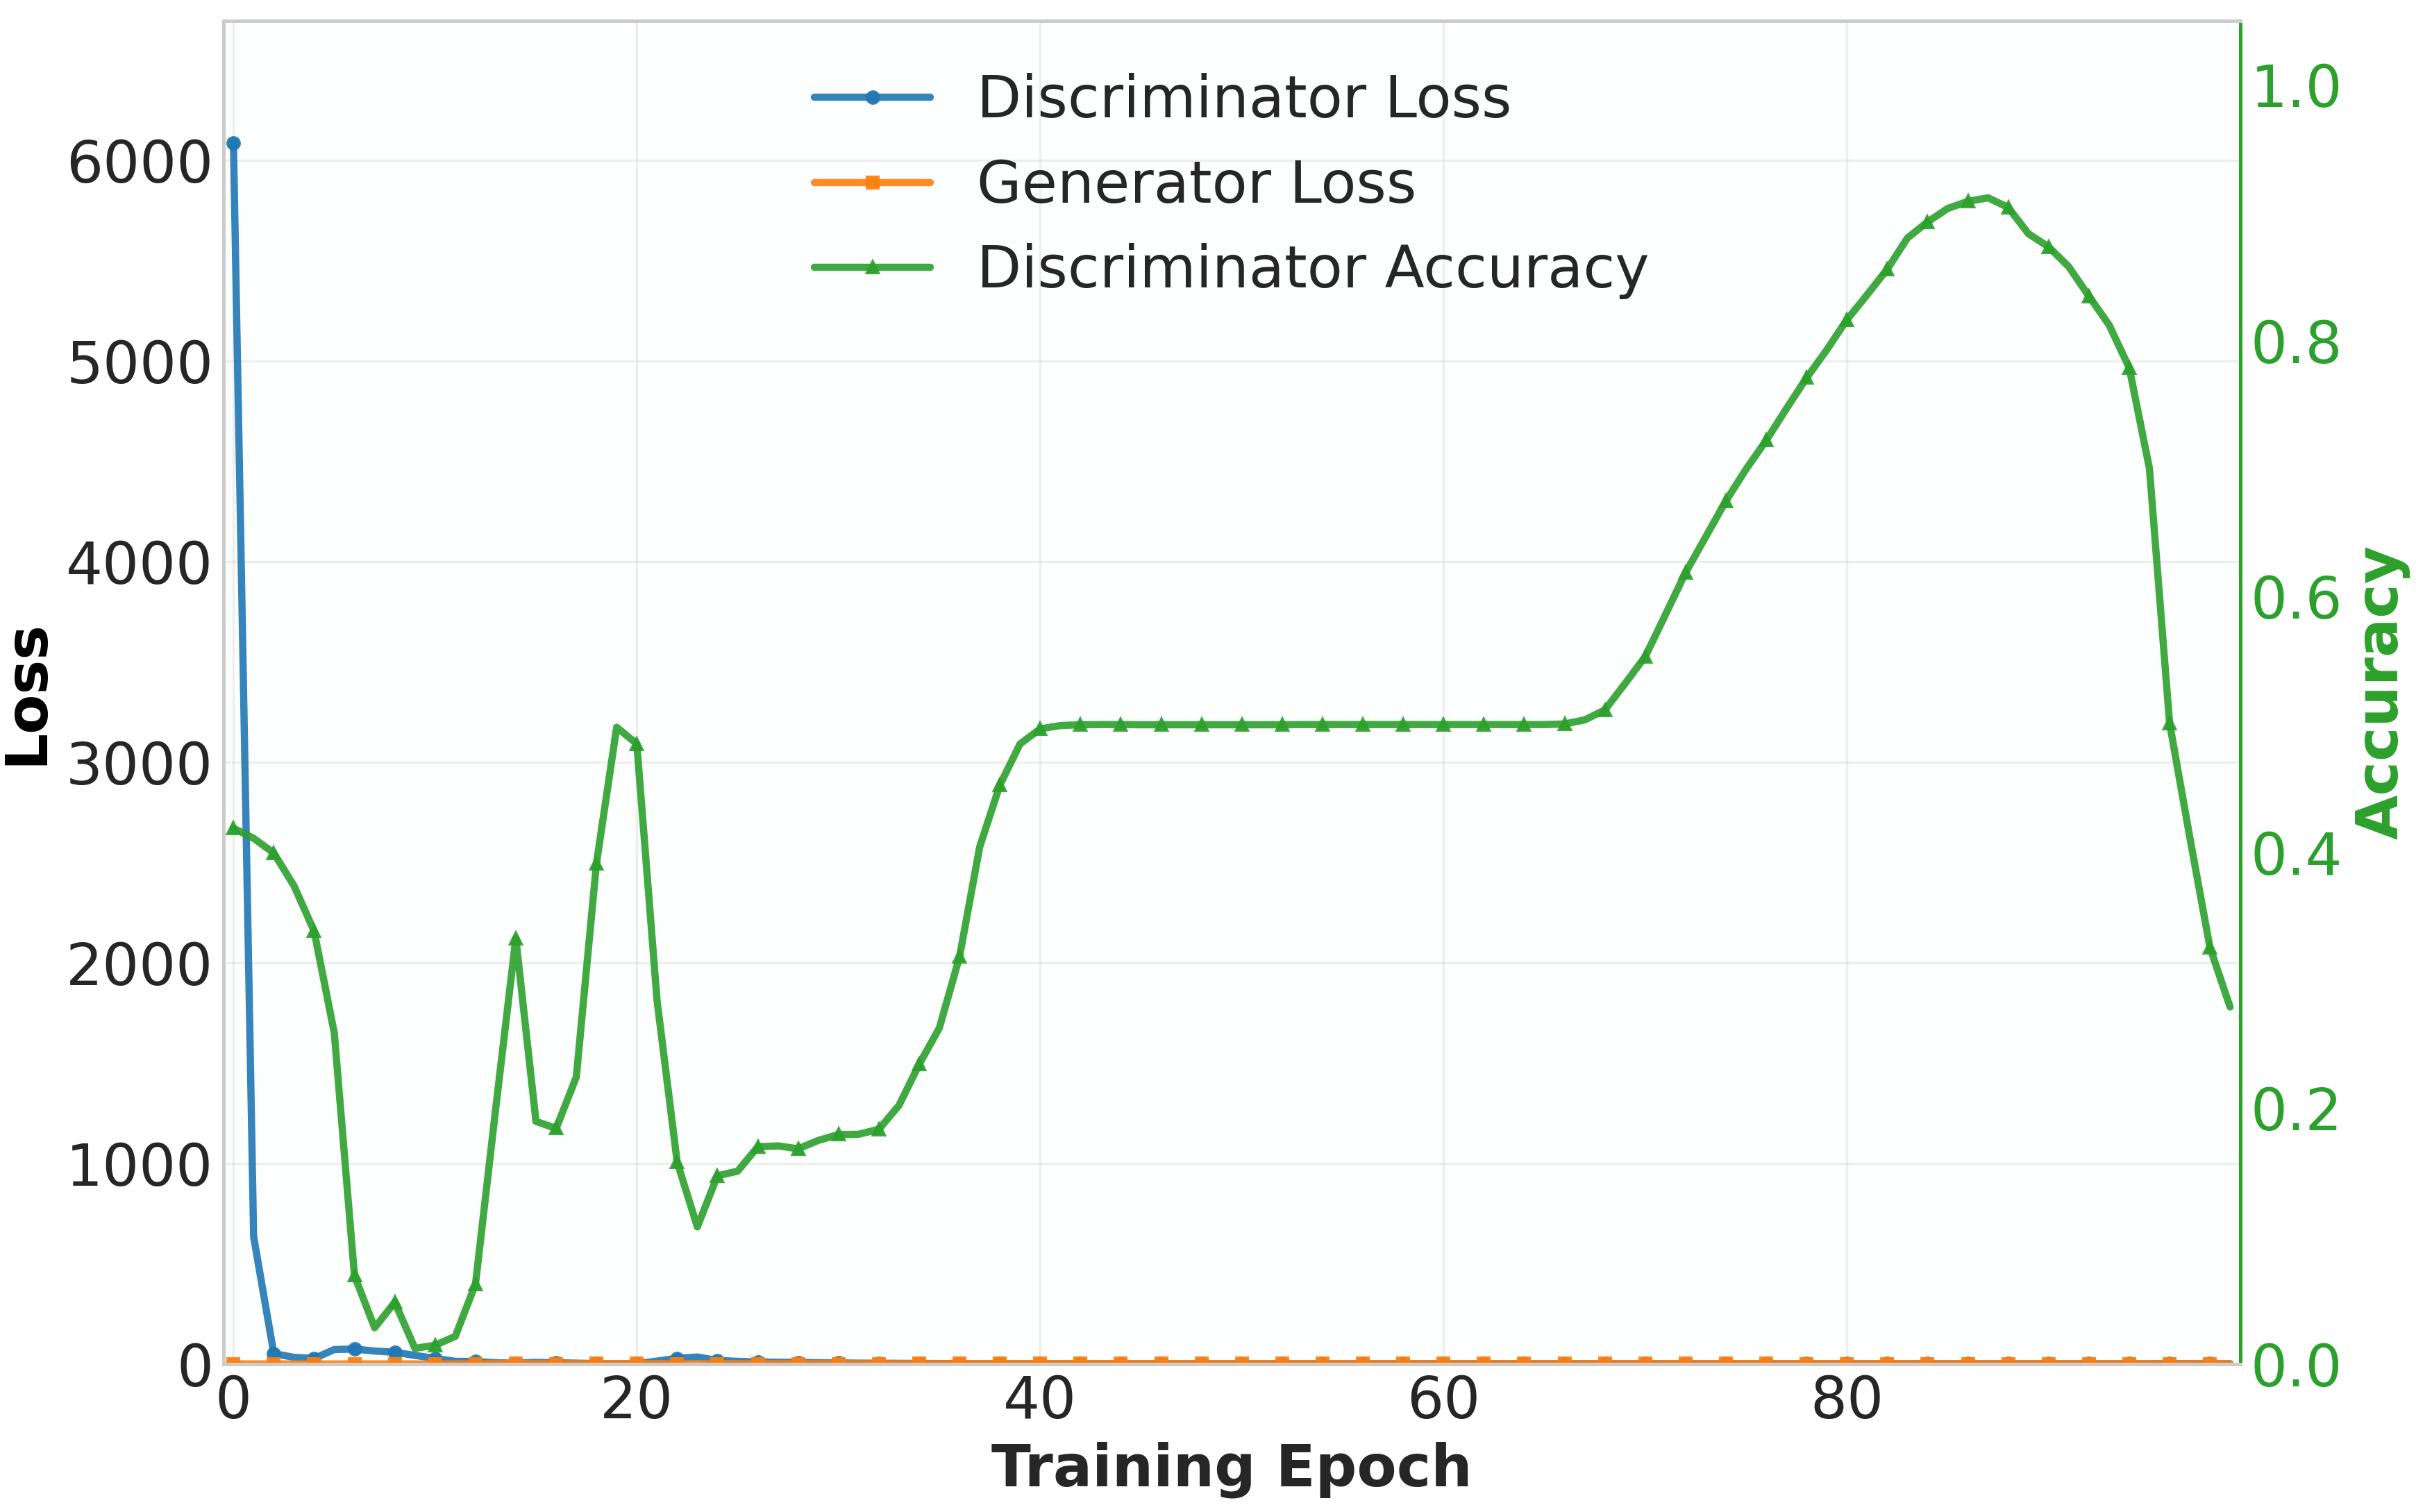

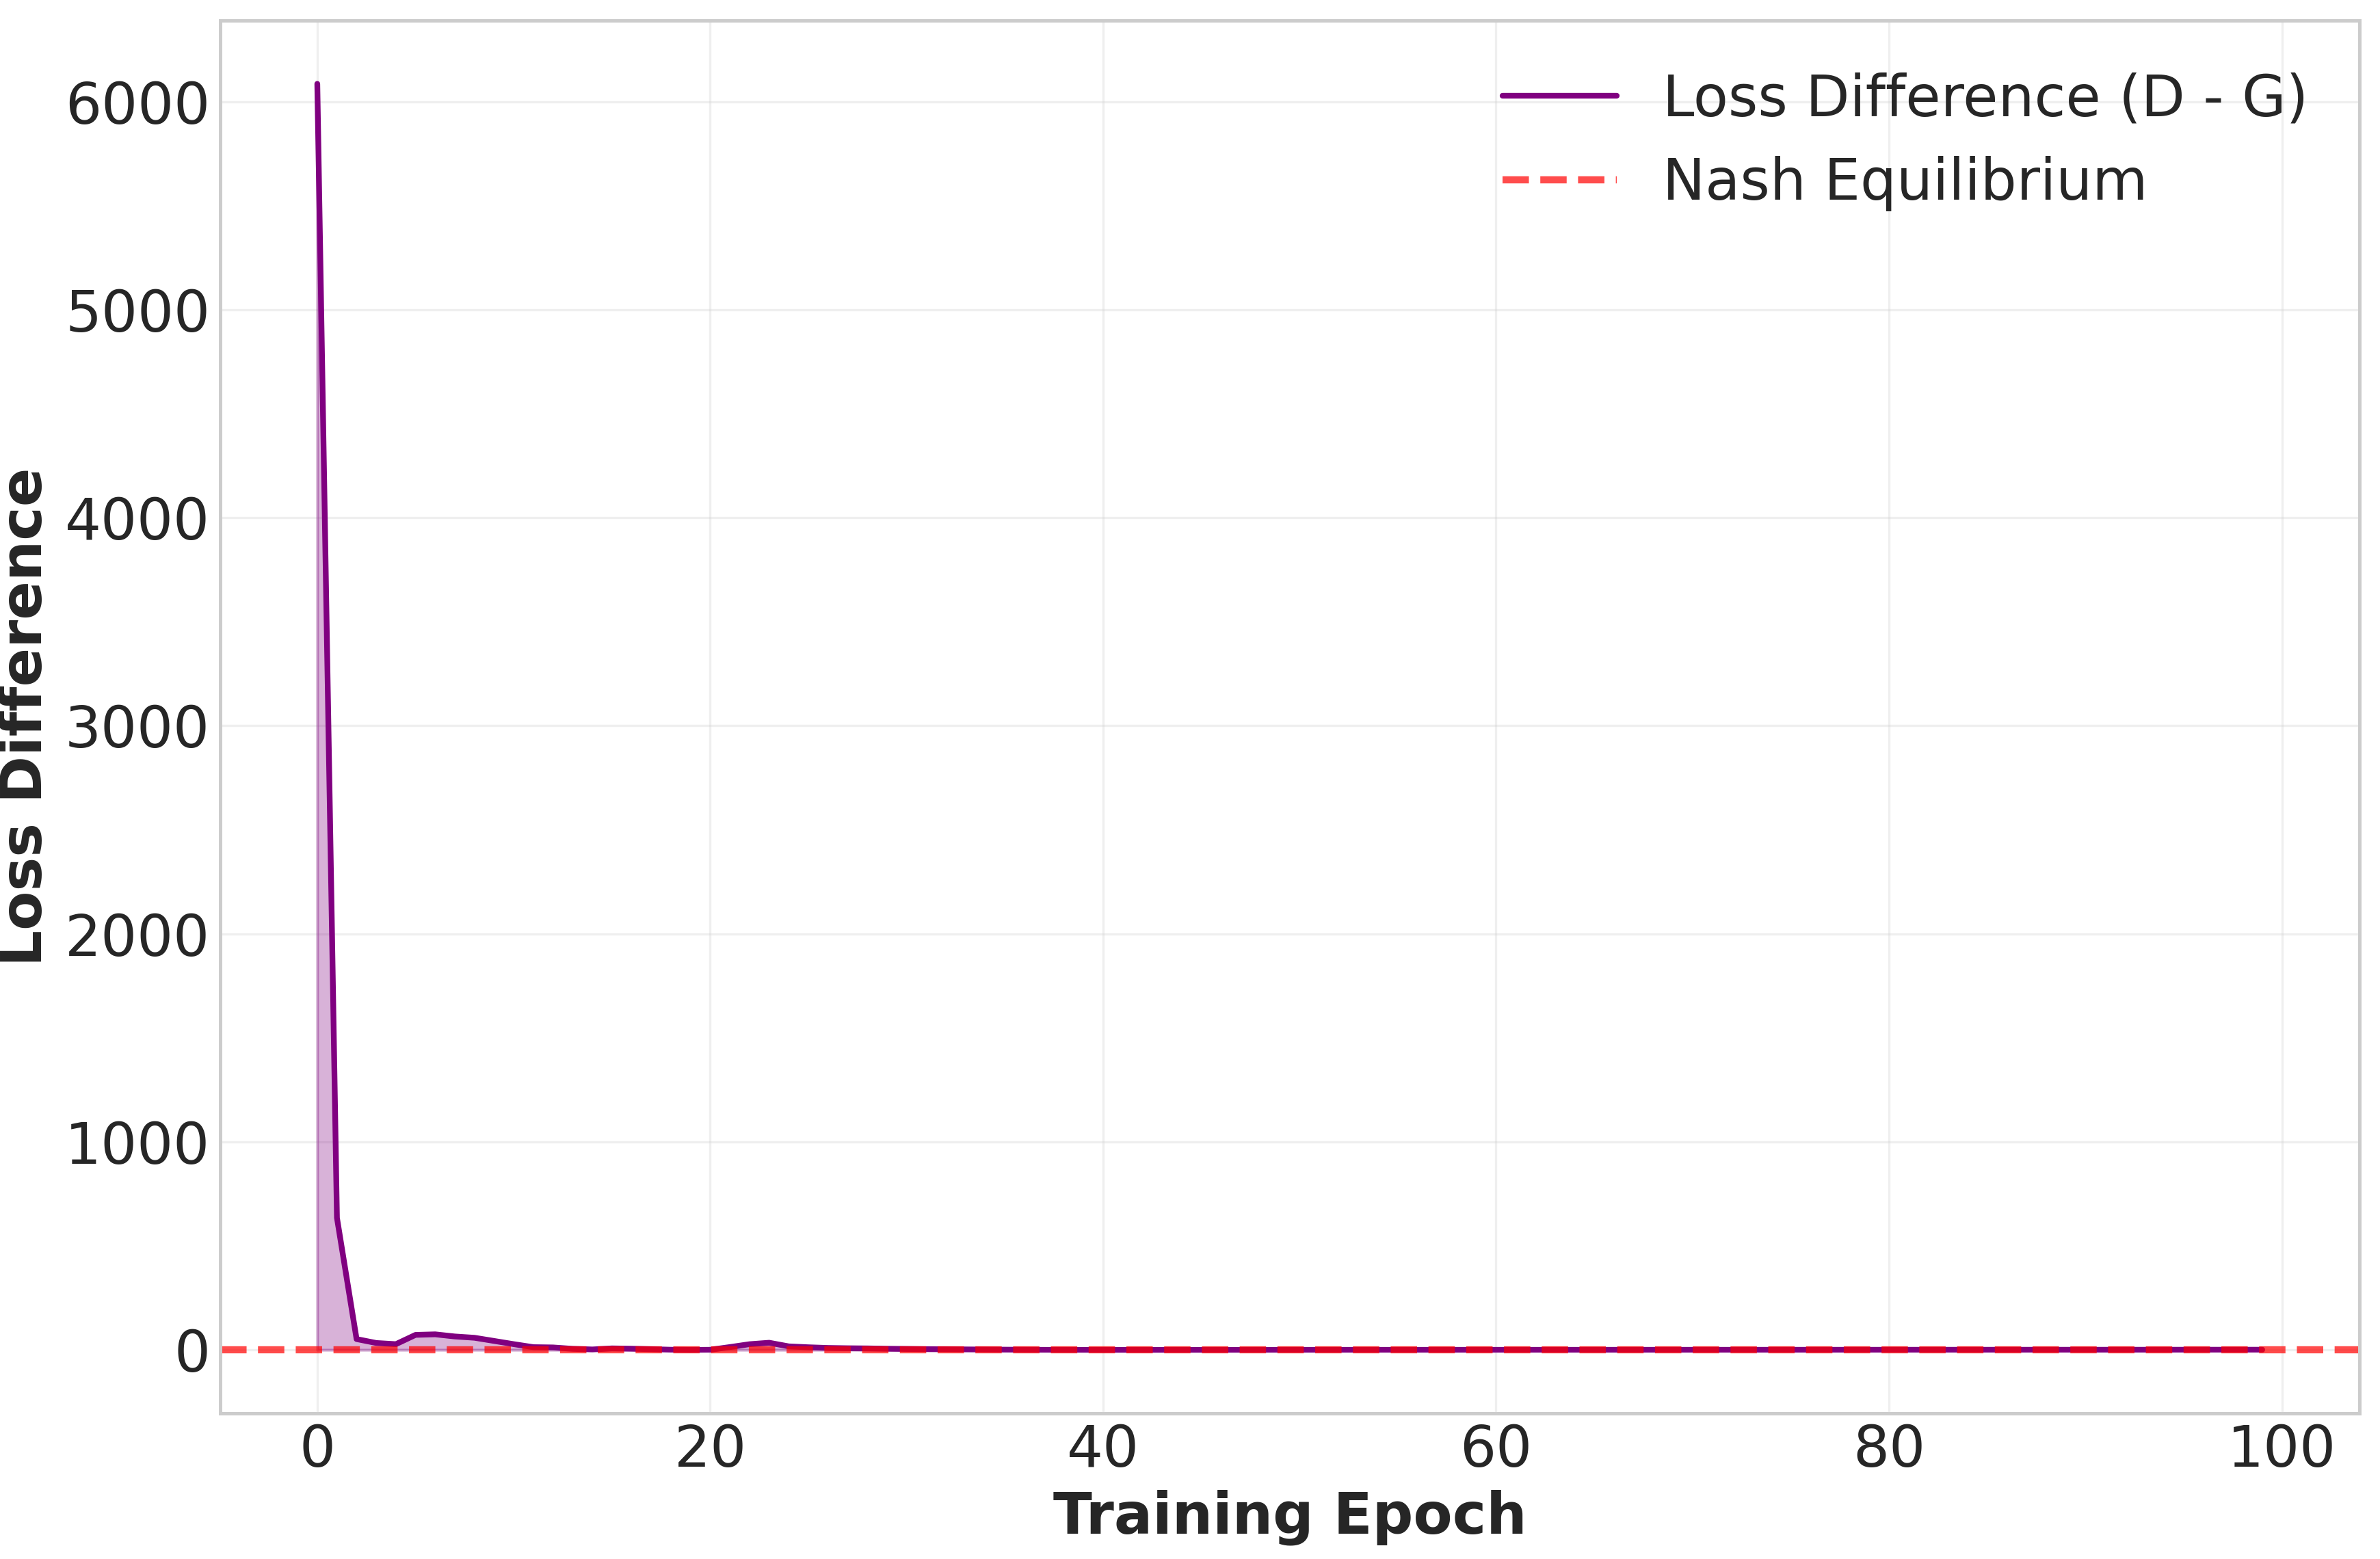

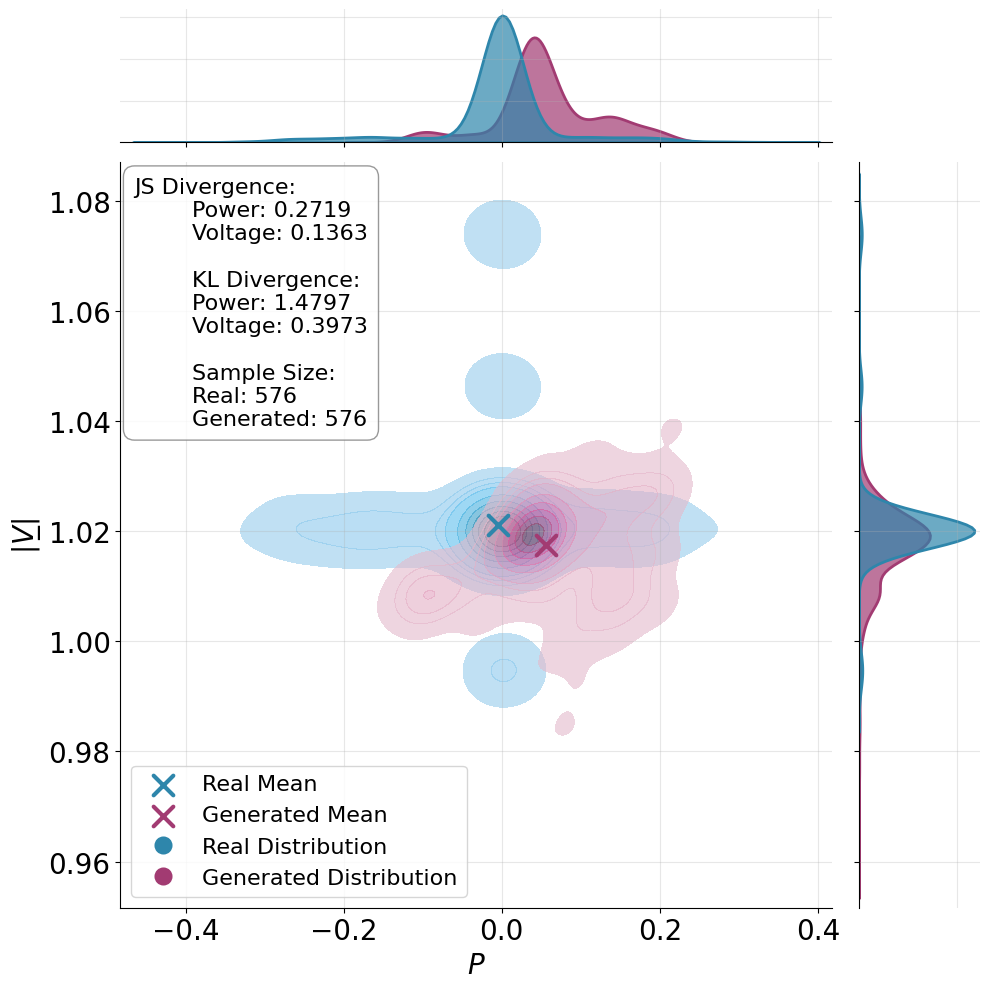

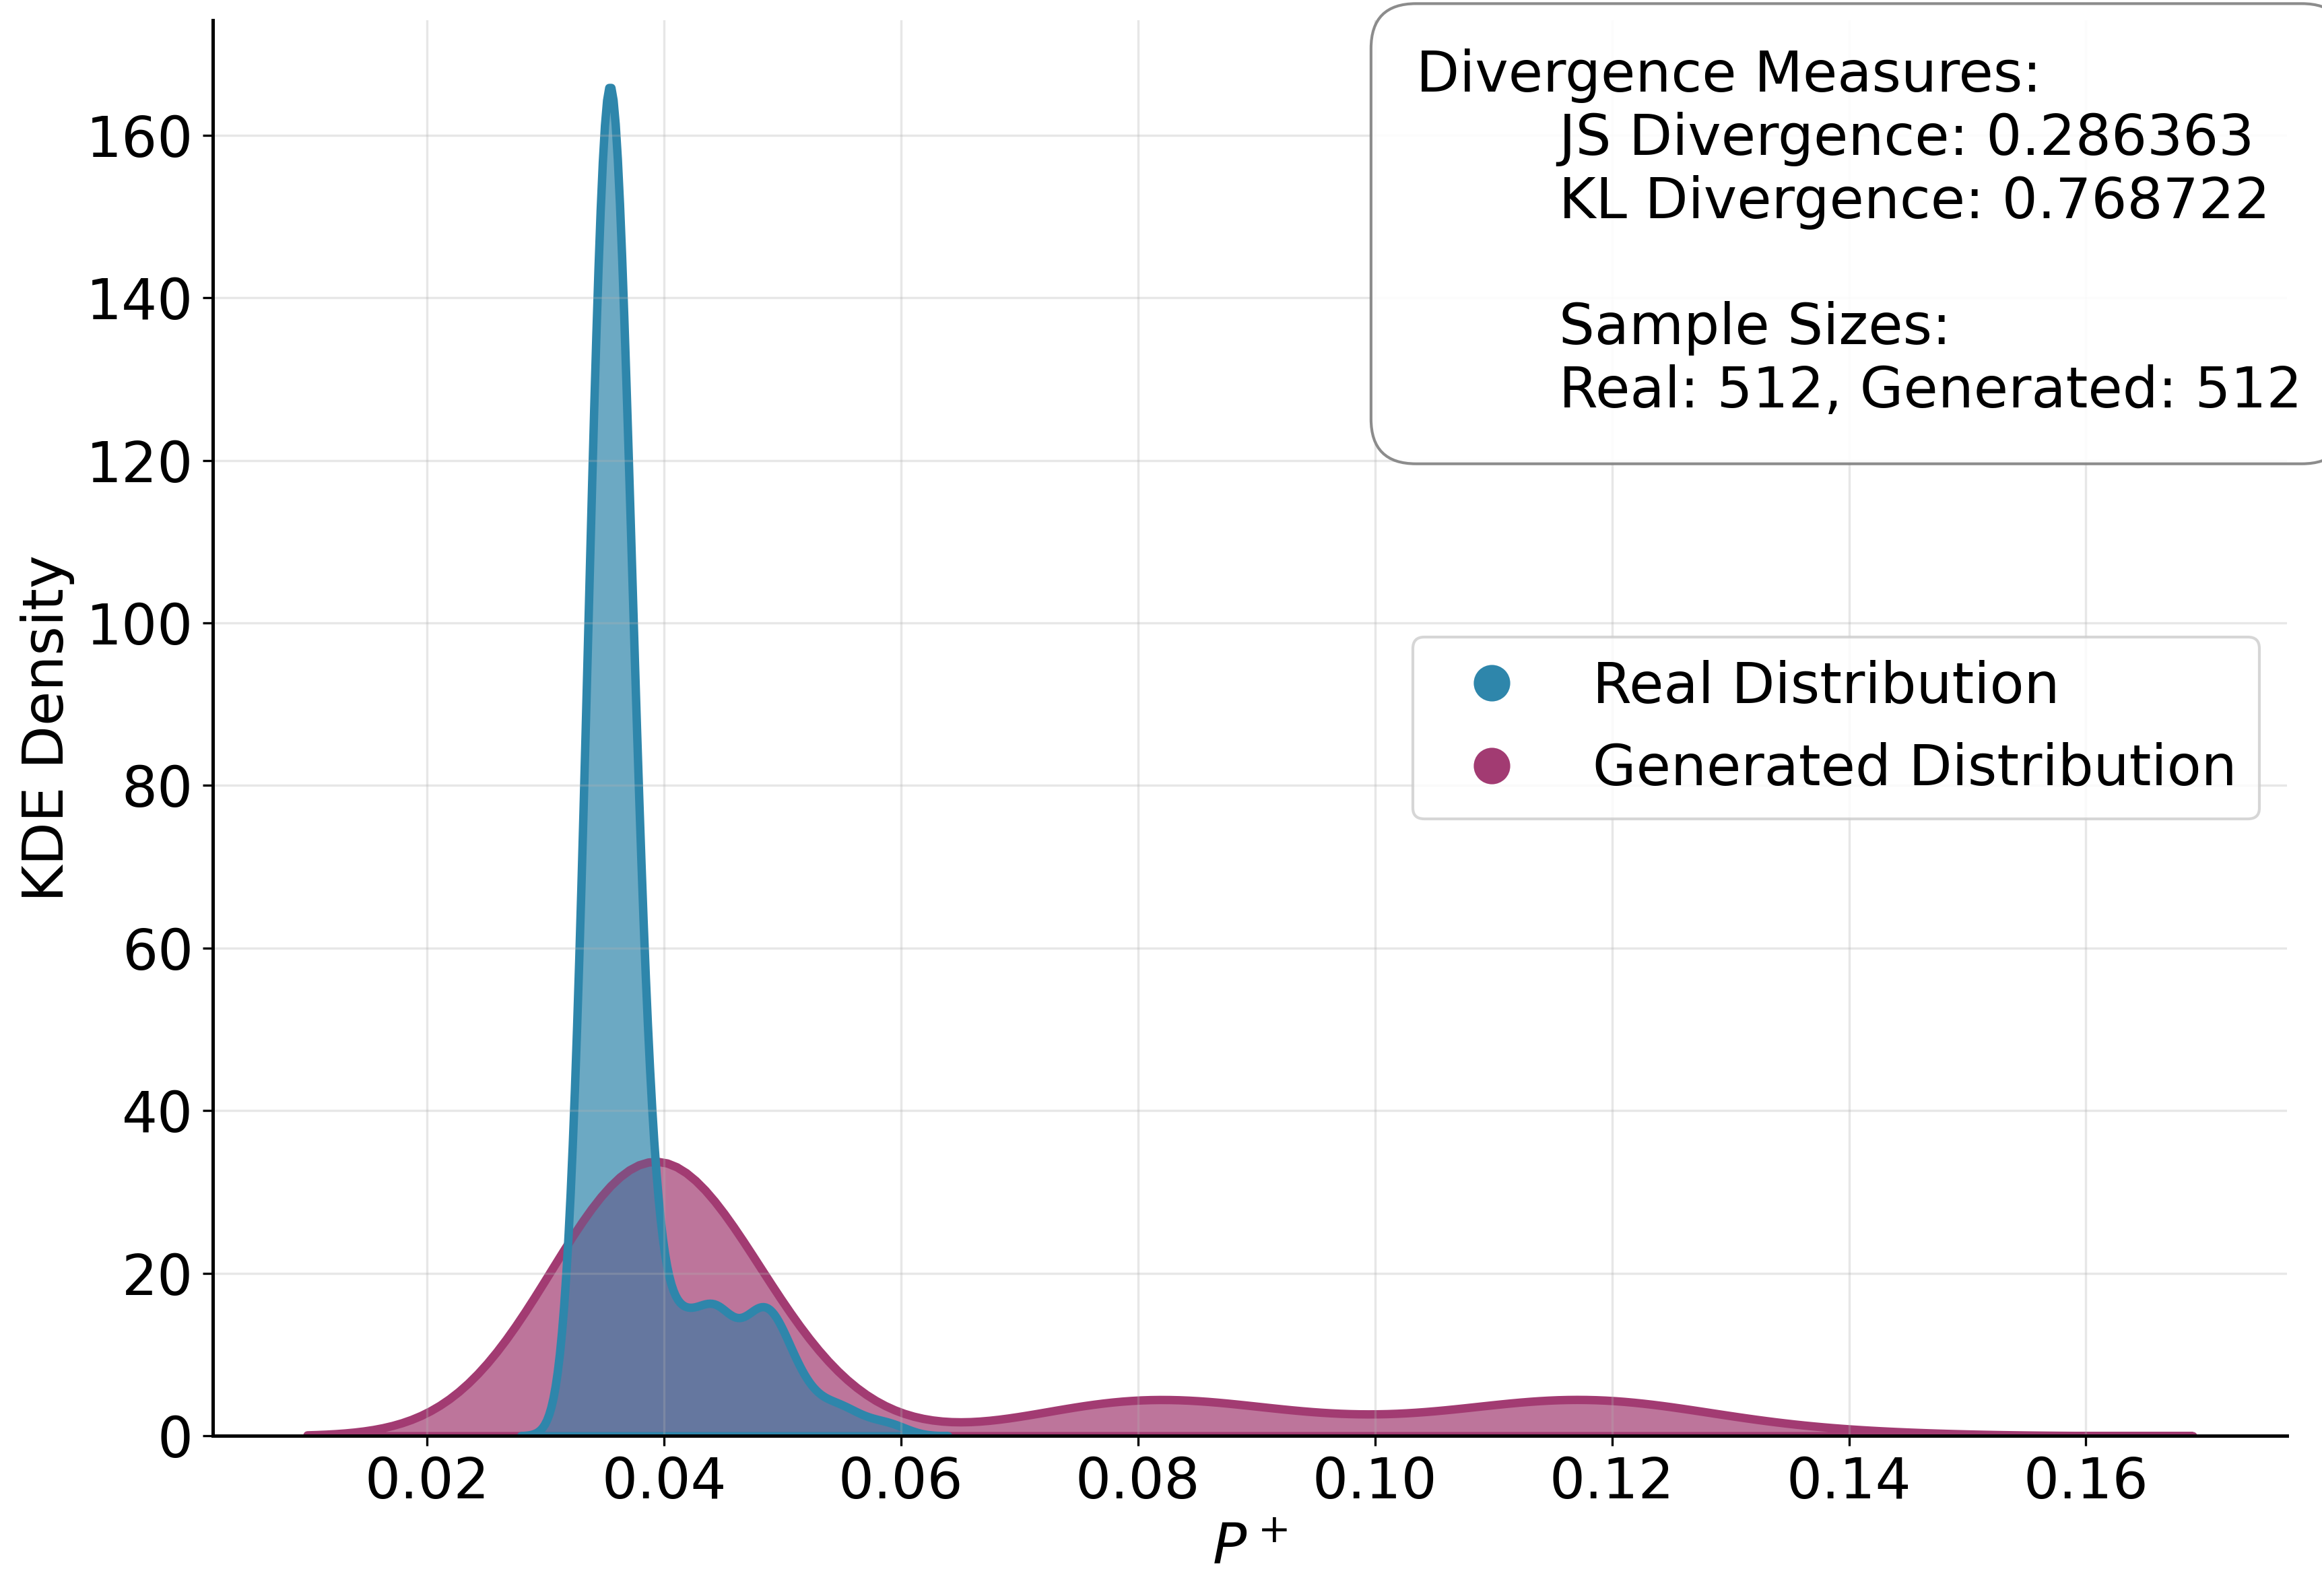

In [1]:
import os 
import sys 
import joblib 
import torch 
from typing import Literal, Tuple
import seaborn as sns 
import torch
import matplotlib.pyplot as plt
import torch.nn as nn 
from torch_geometric.utils import to_dense_adj, dense_to_sparse, to_dense_batch
from torch_geometric.nn.dense import dense_diff_pool
from math import ceil
from torch.optim import Optimizer
from torch_geometric.loader import DataLoader
import time 
import pandas as pd 
import numpy as np
import random 

from scipy import stats
from scipy import spatial
from scipy import special 
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# to access the models and utils 
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

from src.dataset.custom_dataset import DiscDataset, GenDataset
from utils.model_utils import save_model
from utils.ppnet_utils import initialize_network 
from utils.load_data_utils import load_sampled_input_data 
from utils.gen_utils import dataset_splitter, load_config, get_device,scale_numeric_columns, inverse_scale
from src.model.graph_model import DiffPoolDiscriminator, NEGATGenerator

seeds = [0]

all_validation_d_losses = pd.DataFrame(columns=seeds)

all_validation_d_accuracies = pd.DataFrame(columns=seeds)

all_validation_g_losses = pd.DataFrame(columns=seeds)

all_generated_p_values = pd.DataFrame(columns=seeds)
all_real_p_values = pd.DataFrame(columns=seeds)

all_generated_v_values = pd.DataFrame(columns=seeds)
all_real_v_values = pd.DataFrame(columns=seeds)

all_generated_pedge_values = pd.DataFrame(columns=seeds)
all_real_pedge_values = pd.DataFrame(columns=seeds)

for seed in seeds: 
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    config = load_config('config_gan.yaml')

    device = get_device(config['device'])

    net = initialize_network(config['data']['net_name'], else_load=config['data']['load_std'])

    # # make datasets and loader for Generator 
    sampled_input_data_G = load_sampled_input_data(sc_type=config['data']['gen_scenario_type'], 
                                                   net=net, 
                                                   num_samples=config['data']['num_samples'], 
                                                   noise=config['data']['noise'])

    # # node input feature sparsity 
    nif_sparsity = np.count_nonzero(sampled_input_data_G['node_mask']) / sampled_input_data_G['node_mask'].numpy().size * 100
    eif_sparsity = np.count_nonzero(sampled_input_data_G['edge_mask'][:,:,0]) / sampled_input_data_G['edge_mask'][:,:,0].numpy().size * 100

    print(f"Sparsity of PV measurements at Buses = {nif_sparsity:.1f}%")
    print(f"Sparsity of P+ measurements at Lines = {eif_sparsity:.1f}%")

    dataset_G = GenDataset(model_name=config['model_G']['name'], sampled_input_data=sampled_input_data_G)

    (train_loader_G, val_loader_G, test_loader_G), _ = dataset_splitter(dataset_G,
                                                                batch_size=config['loader']['batch_size'])


    # make datasets and loader for Discriminator
    sampled_input_data_D = load_sampled_input_data(sc_type=config['data']['dis_scenario_type'], 
                                                net=net, 
                                                num_samples=config['data']['num_samples'],
                                                p_std=config['data']['load_std'],
                                                noise=config['data']['noise'],
                                                p_true=1, # all are power flow results 
                                                )

 
    dataset_D = DiscDataset(sampled_input_data=sampled_input_data_D)

    (train_loader_D, val_loader_D, test_loader_D), _ = dataset_splitter(dataset=dataset_D, 
                                                                        batch_size=config['loader']['batch_size'])


    # instantiate model, optimizer and schedular for Generator 
    model_G = NEGATGenerator(node_input_features=dataset_G[0][0].x.shape[-1], 
                        list_node_hidden_features=config['model_G']['list_node_hidden_features'], # [128,64], 
                        node_out_features=config['model_G']['node_out_features'], # 64, 
                        k_hop_node=config['model_G']['k_hop_node'], #1, 
                        edge_input_features=dataset_G[0][1].x.shape[-1],
                        list_edge_hidden_features=config['model_G']['list_edge_hidden_features'], #[128,64], 
                        edge_output_features=config['model_G']['edge_out_features'], #64, 
                        k_hop_edge=config['model_G']['k_hop_edge'], #1, 
                        gat_out_features=config['model_G']['gat_out_features'], #32, 
                        gat_head=config['model_G']['gat_head'], #2, 
                        device=device)

    optimizer_G = torch.optim.Adam(model_G.parameters(), 
                                lr=config['training_G']['lr'], 
                                weight_decay=config['training_G']['weight_decay'])

    schedular_G = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_G, 
                                                        mode='min', 
                                                        factor=0.1, 
                                                        min_lr=config['training_G']['schedular_min_lr'])

    total_params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
    print(f'Total number of parameters of model {model_G}: {total_params_G}')


    # instantiate model, optimizer and schedular for Discriminator 
    model_D = DiffPoolDiscriminator(in_channel=dataset_D[0].x.shape[-1], 
                                hidden_channel=config['model_D']['hidden_channel'], 
                                out_channel=config['model_D']['out_channel'], 
                                num_nodes=len(net.bus.index))

    total_params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
    print(f'Total number of parameters of model {model_D}: {total_params_D}')

    optimizer_D = torch.optim.Adam(model_D.parameters(), 
                                lr=config['training_D']['lr'], 
                                weight_decay=config['training_D']['weight_decay'])

    schedular_D = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_D, 
                                                        mode='min', 
                                                        factor=0.1, 
                                                        min_lr=config['training_D']['schedular_min_lr'])

    def train_epoch_gan(model_G: nn.Module, 
                        model_D: nn.Module, 
                        loader_G: DataLoader, 
                        loader_D: DataLoader, 
                        optimizer_G: Optimizer, 
                        optimizer_D: Optimizer, 
                        disc_iter: int,
                        gen_iter: int,
                        device: Literal['cpu','cuda','mps'] = 'cpu') -> Tuple: 
        model_G.train()
        model_D.train()
        
        criterion = nn.BCEWithLogitsLoss()

        # BCE Loss 
        dis_loss = 0
        gen_loss = 0

        # accuracy of discriminator  
        correct = 0 
        total = 0
        

        for fake_batch, real_batch in zip(loader_G, loader_D): 
            # Train discriminator 
            for _ in range(disc_iter): 
                optimizer_D.zero_grad()
                # discriminator output logit for real samplesa as inputs
                D_real_output = model_D(real_batch.x, real_batch.edge_index, real_batch.edge_attr, real_batch.batch)
                
                # loss of identifying real samples 
                real_loss = criterion(D_real_output, real_batch.y.to(device))

                # accuracy of identifying real samples as real
                D_real_output_binary = (torch.sigmoid(D_real_output) > 0.5).float()
                correct += (D_real_output_binary == real_batch.y.to(device)).sum().item()
                total += real_batch.y.shape[0]
                

                # discriminator output logit for fake samples as inputs 
                D_fake_output = model_D(model_G(fake_batch)[0], fake_batch[0].edge_index, model_G(fake_batch)[1], fake_batch[0].batch)

                # loss of identifying fake samples 
                fake_loss = criterion(D_fake_output, fake_batch[0].y.to(device))

                # accuracy of identifying fake samples as fake 
                D_fake_output_binary = (torch.sigmoid(D_fake_output) > 0.5).float()
                correct += (D_fake_output_binary == fake_batch[0].y.to(device)).sum().item()
                total += fake_batch[0].y.shape[0]

                dis_net_loss = real_loss + fake_loss 
                dis_net_loss.backward()
                optimizer_D.step()
                dis_loss += dis_net_loss.item()
            
            for _ in range(gen_iter):
                # Train the generator to fool the discriminator 
                optimizer_G.zero_grad()
                G_D_fake_output = model_D(model_G(fake_batch)[0], fake_batch[0].edge_index, model_G(fake_batch)[1], fake_batch[0].batch)
                gen_train_loss = criterion(G_D_fake_output, fake_batch[0].y_fool.to(device))

                gen_train_loss.backward()
                optimizer_G.step()
                gen_loss += gen_train_loss.item()
        
        disc_accuracy = correct / total 
        return dis_loss/(len(loader_D) + len(loader_G)), disc_accuracy, gen_loss/len(loader_G)

    def val_epoch_gan(model_G: nn.Module, 
                        model_D: nn.Module, 
                        loader_G: DataLoader, 
                        loader_D: DataLoader, 
                        device: Literal['cpu','cuda','mps'] = 'cpu') -> Tuple: 

        model_G.eval()
        model_D.eval()

        criterion = nn.BCEWithLogitsLoss()

        # BCE Loss 
        dis_loss = 0
        gen_loss = 0

        # accuracy of discriminator  
        correct = 0 
        total = 0


        for fake_batch, real_batch in zip(loader_G, loader_D): 
            # Train discriminator 
            
            # discriminator output logit for real samplesa as inputs
            D_real_output = model_D(real_batch.x, real_batch.edge_index, real_batch.edge_attr, real_batch.batch)
                
            # loss of identifying real samples 
            real_loss = criterion(D_real_output, real_batch.y.to(device))

            # accuracy of identifying real samples as real
            D_real_output_binary = (torch.sigmoid(D_real_output) > 0.5).float()
            correct += (D_real_output_binary == real_batch.y.to(device)).sum().item()
            total += real_batch.y.shape[0]
                

            # discriminator output logit for fake samples as inputs 
            D_fake_output = model_D(model_G(fake_batch)[0], fake_batch[0].edge_index, model_G(fake_batch)[1], fake_batch[0].batch)

            # loss of identifying fake samples 
            fake_loss = criterion(D_fake_output, fake_batch[0].y.to(device))

            # accuracy of identifying fake samples as fake 
            D_fake_output_binary = (torch.sigmoid(D_fake_output) > 0.5).float()
            correct += (D_fake_output_binary == fake_batch[0].y.to(device)).sum().item()
            total += fake_batch[0].y.shape[0]

            dis_net_loss = real_loss + fake_loss 
            dis_loss += dis_net_loss.item()
            
            # Train the generator to fool the discriminator 
            G_D_fake_output = model_D(model_G(fake_batch)[0], fake_batch[0].edge_index, model_G(fake_batch)[1], fake_batch[0].batch)
            gen_train_loss = criterion(G_D_fake_output, fake_batch[0].y_fool.to(device))

            gen_loss += gen_train_loss.item()
        
        disc_accuracy = correct / total

        return dis_loss/(len(loader_D) + len(loader_G)), disc_accuracy, gen_loss/len(loader_G)

    num_epoch = config['training_GAN']['num_epoch']
    disc_iter = config['training_GAN']['disc_iter']
    gen_iter = config['training_GAN']['gen_iter']

    train_d_losses, train_d_accuracies, train_g_losses = [],[],[]
    val_d_losses, val_d_accuracies, val_g_losses = [], [], []

    start_tr = time.perf_counter()
    early_stop = 0
    for epoch in range(num_epoch):
        train_d_loss, train_d_accuracy, train_g_loss = train_epoch_gan(model_G = model_G, 
                                                                    model_D = model_D, 
                                                                    loader_G = train_loader_G, 
                                                                    loader_D = train_loader_D, 
                                                                    optimizer_G = optimizer_G, 
                                                                    optimizer_D = optimizer_D, 
                                                                    disc_iter = disc_iter,
                                                                    gen_iter=gen_iter,
                                                                    device = device)
        
        val_d_loss, val_d_accuracy, val_g_loss = val_epoch_gan(model_G = model_G, 
                                                            model_D = model_D, 
                                                            loader_G = val_loader_G, 
                                                            loader_D = val_loader_D, 
                                                            device = device)
        train_d_losses.append(train_d_loss)
        train_d_accuracies.append(train_d_accuracy)
        train_g_losses.append(train_g_loss)

        val_d_losses.append(val_d_loss)
        val_d_accuracies.append(val_d_accuracy)
        val_g_losses.append(val_g_loss)
        
        if schedular_G != None: 
            schedular_G.step(val_g_loss)
        schedular_G_last_lr = schedular_G.get_last_lr()[0]
        
        if schedular_D != None: 
            schedular_D.step(val_d_loss)
        schedular_D_last_lr = schedular_D.get_last_lr()[0]

        if epoch % max(1, int(0.05 * num_epoch)) == 0: 
            print(f"At epoch: {epoch}, training: {train_d_loss:.3e}, {train_d_accuracy:.2f}, {train_g_loss:.3e},\
                validation: {val_d_loss:.3e}, {val_d_accuracy:.2f}, {val_g_loss:.3e}, lr: {schedular_D_last_lr:.1e}, {schedular_G_last_lr:.1e}")

    end_tr = time.perf_counter()
    elapsed_tr = end_tr - start_tr 

    all_validation_d_losses[seed] = val_d_losses
    all_validation_d_accuracies[seed] = val_d_accuracies
    all_validation_g_losses[seed] = val_g_losses

    print(f"GAN training took {elapsed_tr:.3f} seconds.")

    test_d_loss, test_d_accuracy, test_g_loss = val_epoch_gan(model_G = model_G, 
                                                            model_D = model_D, 
                                                            loader_G = test_loader_G, 
                                                            loader_D = test_loader_D, 
                                                            device = device)
    print(f"Test Performance: d_loss: {test_d_loss:.3e}, d_accuracy: {test_d_accuracy:.2f}, g_loss: {test_g_loss:.3e}")


    from datetime import datetime 
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    report_dir = f"{parent_dir}/notebooks/rq4_gan_results_seed/{current_time}_{seed}/"
    os.makedirs(report_dir, exist_ok=True)

    from matplotlib.ticker import MaxNLocator
    from matplotlib.patches import Rectangle

    # Set publication-quality style
    plt.style.use('seaborn-v0_8-whitegrid')  # Clean, professional look
    sns.set_palette("husl")  # Better color palette for academic figures

    # Configure matplotlib for publication quality
    fontsize=20
    plt.rcParams.update({
        'font.size': fontsize,
        # 'font.family': 'serif',
        # 'font.serif': ['Times New Roman', 'DejaVu Serif'],
        'axes.labelsize': fontsize,
        'axes.titlesize': fontsize,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'legend.fontsize': 20,
        # 'figure.titlesize': ,
        # 'text.usetex': True,  # Set to True if LaTeX is available
        'axes.linewidth': 1.2,
        'grid.alpha': 0.3,
        'lines.linewidth': 2.5,
        'lines.markersize': 6
    })

    # Create figure with proper DPI for publication
    fig, ax1 = plt.subplots(figsize=(12, 8), dpi=300)

    # Define professional color scheme
    colors = {
        'discriminator': '#1f77b4',  # Blue
        'generator': '#ff7f0e',     # Orange
        'accuracy': '#2ca02c'       # Green
    }

    # Plot losses with enhanced styling
    epochs = range(len(train_d_losses))

    line1 = ax1.plot(epochs, train_d_losses, 
                    color=colors['discriminator'], 
                    linewidth=2.5, 
                    label='Discriminator Loss',
                    marker='o', 
                    markersize=4, 
                    markevery=max(1, len(epochs)//40),  # Show markers every 5% of epochs
                    alpha=0.9)

    line2 = ax1.plot(epochs, train_g_losses, 
                    color=colors['generator'], 
                    linewidth=2.5, 
                    label='Generator Loss',
                    marker='s', 
                    markersize=4, 
                    markevery=max(1, len(epochs)//40),
                    alpha=0.9)

    # Create secondary y-axis for accuracy
    ax2 = ax1.twinx()
    line3 = ax2.plot(epochs, train_d_accuracies, 
                    color=colors['accuracy'], 
                    linewidth=2.5, 
                    label='Discriminator Accuracy',
                    marker='^', 
                    markersize=4, 
                    markevery=max(1, len(epochs)//40),
                    alpha=0.9)

    # Enhanced axis formatting
    ax1.set_xlabel('Training Epoch', fontweight='bold')
    ax1.set_ylabel('Loss', fontweight='bold', color='black')
    ax2.set_ylabel('Accuracy', fontweight='bold', color=colors['accuracy'])

    # Set title with better formatting
    # fig.suptitle('GAN Training Dynamics: Loss and Accuracy Evolution', 
                #  fontsize=16, fontweight='bold', y=0.95)

    # Improve grid appearance
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
    ax2.grid(False)  # Avoid grid overlap

    # Set axis limits with padding
    ax1.set_xlim(-0.5, len(epochs)-0.5)
    ax1.set_ylim(0, max(max(train_d_losses), max(train_g_losses)) * 1.1)
    ax2.set_ylim(0, 1.05)  # Assuming accuracy is between 0 and 1

    # # Format ticks
    # ax1.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))
    # ax1.yaxis.set_major_locator(MaxNLocator(nbins=8))
    # ax2.yaxis.set_major_locator(MaxNLocator(nbins=6))

    # Color the right y-axis labels to match the accuracy line
    ax2.tick_params(axis='y', labelcolor=colors['accuracy'])
    ax2.spines['right'].set_color(colors['accuracy'])

    # Create combined legend with better positioning
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, 
            loc='upper center', 
            #   bbox_to_anchor=(0.98, 0.3),
            )

    # Add convergence annotations (optional - customize based on your data)
    # if len(train_d_losses) > 50:  # Only if sufficient training epochs
    #     # Find approximate convergence points
    #     convergence_epoch = len(train_d_losses) // 2  # Adjust based on your data
        
    #     # Add vertical line to highlight convergence region
    #     ax1.axvline(x=convergence_epoch, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    #     ax1.annotate('Approximate Convergence', 
    #                 xy=(convergence_epoch, max(train_g_losses)/2), 
    #                 xytext=(convergence_epoch + len(epochs)*0.1, max(train_g_losses)*0.8),
    #                 arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7),
    #                 fontsize=10, color='gray')

    # Improve layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Make room for title

    # Add subtle background shading to distinguish loss and accuracy regions
    # (optional enhancement)
    ax1.axhspan(ax1.get_ylim()[0], ax1.get_ylim()[1], 
            facecolor='lightblue', alpha=0.02, zorder=0)
    # ax1.set_ylim([-1,10])

    # Save figure in multiple formats for publication
    plt.savefig(parent_dir + f'/notebooks/rq4_gan_results_seed/{current_time}_{seed}/FIG_ch_results_gan_training_dynamics.pdf', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.savefig(parent_dir + f'/notebooks/rq4_gan_results_seed/{current_time}_{seed}/FIG_ch_results_gan_training_dynamics.png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')


    # Optional: Create a separate convergence analysis plot
    def create_convergence_plot():
        """Create a secondary plot focusing on convergence analysis"""
        fig, ax2 = plt.subplots(1, 1, figsize=(12, 8), dpi=300, sharex=True)
        
        # # Top plot: Loss difference and moving averages
        # window_size = max(1, len(train_d_losses) // 20)
        # d_loss_ma = np.convolve(train_d_losses, np.ones(window_size)/window_size, mode='valid')
        # g_loss_ma = np.convolve(train_g_losses, np.ones(window_size)/window_size, mode='valid')
        
        # ax1.plot(epochs, train_d_losses, alpha=0.3, color=colors['discriminator'])
        # ax1.plot(epochs, train_g_losses, alpha=0.3, color=colors['generator'])
        # ax1.plot(range(window_size-1, len(epochs)), d_loss_ma, 
        #          color=colors['discriminator'], linewidth=2, label='Discriminator Loss (MA)')
        # ax1.plot(range(window_size-1, len(epochs)), g_loss_ma, 
        #          color=colors['generator'], linewidth=2, label='Generator Loss (MA)')
        
        # ax1.set_ylabel('Loss (Moving Average)', fontweight='bold')
        # # ax1.set_title('Convergence Analysis: Moving Averages', fontweight='bold')
        # ax1.legend()
        # ax1.grid(True, alpha=0.3)
        
        # Bottom plot: Loss difference
        loss_diff = np.array(train_d_losses) - np.array(train_g_losses)
        ax2.plot(epochs, loss_diff, color='purple', linewidth=2, label='Loss Difference (D - G)')
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Nash Equilibrium')
        ax2.fill_between(epochs, loss_diff, alpha=0.3, color='purple')
        
        ax2.set_xlabel('Training Epoch', fontweight='bold')
        ax2.set_ylabel('Loss Difference', fontweight='bold')
        # ax2.set_ylim([-1,10])
        # ax2.set_title('Nash Equilibrium Analysis', fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(parent_dir + f'/notebooks/rq4_gan_results_seed/{current_time}_{seed}/FIG_ch_results_gan_convergence_analysis.pdf', dpi=300, bbox_inches='tight')


    # Uncomment to create convergence analysis plot
    create_convergence_plot()

    try: 
        from sklearn.preprocessing import StandardScaler 

        batch_G = next(iter(test_loader_G))
        scaled_real_pv = batch_G[0].x_pfr
        scaled_real_p_edge = batch_G[1].x_pfr[:,0]
        scaled_gen_pv, scaled_gen_p_edge = model_G(batch_G)

        real_pv = inverse_scale(scaled_real_pv, scaler=sampled_input_data_G['scaler_node'])
        all_real_p_values[seed] = real_pv[:,0].detach().cpu().numpy()
        all_real_v_values[seed] = real_pv[:,1].detach().cpu().numpy()

        gen_pv = inverse_scale(scaled_gen_pv, scaler=sampled_input_data_G['scaler_node'])
        all_generated_p_values[seed] = gen_pv[:,0].detach().cpu().numpy()
        all_generated_v_values[seed] = gen_pv[:,1].detach().cpu().numpy()

        p_edge_mean = sampled_input_data_G['scaler_edge'].mean_[0]
        p_edge_var = sampled_input_data_G['scaler_edge'].var_[0]

        real_p_edge = scaled_real_p_edge * p_edge_var + p_edge_mean
        all_real_pedge_values[seed] = real_p_edge.detach().cpu().numpy()
        
        gen_p_edge = scaled_gen_p_edge * p_edge_var + p_edge_mean
        all_generated_pedge_values[seed] = gen_p_edge.detach().cpu().numpy()

        from scipy.stats import gaussian_kde
        from scipy.special import rel_entr
        from scipy.spatial.distance import jensenshannon

        # Convert tensors to numpy for plotting
        real_v_np = real_pv[:,0].detach().cpu().numpy()
        real_p_np = real_pv[:,1].detach().cpu().numpy()
        generated_v_np = gen_pv[:,0].detach().cpu().numpy()
        generated_p_np = gen_pv[:,1].detach().cpu().numpy()
        real_p_edge_np = real_p_edge.detach().cpu().numpy()
        gen_p_edge_np = gen_p_edge.detach().cpu().numpy()

        # Create labeled DataFrames with better naming
        real_df = pd.DataFrame({
            'Power': real_p_np,
            'Voltage': real_v_np,
            'Type': 'Real Data'
        })

        gen_df = pd.DataFrame({
            'Power': generated_p_np,
            'Voltage': generated_v_np,
            'Type': 'Generated Data'
        })

        # Combine datasets
        combined_data = pd.concat([real_df, gen_df], ignore_index=True)

        # Set up the plot with enhanced styling
        plt.style.use('default')  # Keep default matplotlib style
        sns.set_palette(["#2E86AB", "#A23B72"])  # Professional blue and magenta

        # Create the enhanced jointplot
        g = sns.jointplot(
            data=combined_data,
            x='Power',
            y='Voltage',
            hue='Type',
            kind='kde',
            fill=True,
            alpha=0.6,
            height=10,
            ratio=5,
            space=0.1,
            fontsize=fontsize,
            marginal_kws={'alpha': 0.7, 'linewidth': 2},
            joint_kws={'alpha': 0.6, 'linewidths': 1.5},
            legend=True,  
        )

        # # Enhance the main plot
        g.ax_joint.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)


        # Enhance marginal plots
        g.ax_marg_x.grid(True, alpha=0.3)
        g.ax_marg_y.grid(True, alpha=0.3)

        # Add statistical annotations
        real_power_mean = real_p_np.mean()
        real_voltage_mean = real_v_np.mean()
        gen_power_mean = generated_p_np.mean()
        gen_voltage_mean = generated_v_np.mean()

        # Add mean markers
        g.ax_joint.scatter(real_power_mean, real_voltage_mean, 
                        marker='x', s=200, color='#2E86AB', 
                        linewidth=3, label='Real Mean', zorder=5)
        g.ax_joint.scatter(gen_power_mean, gen_voltage_mean, 
                        marker='x', s=200, color='#A23B72', 
                        linewidth=3, label='Generated Mean', zorder=5)

        # Calculate and display statistical metrics
        def calculate_metrics(real_data, gen_data):
            """Calculate JS and KL divergence for Power and Voltage columns."""
            
            def compute_divergences(real_series, gen_series):
                # Combine data for common evaluation range
                data = np.concatenate([real_series, gen_series])
                x = np.linspace(data.min(), data.max(), 1000)
                
                # KDE estimation
                real_kde = gaussian_kde(real_series)
                gen_kde = gaussian_kde(gen_series)

                # Evaluate densities
                real_prob = real_kde(x)
                gen_prob = gen_kde(x)

                # Add epsilon to avoid zeros
                epsilon = 1e-10
                real_prob += epsilon
                gen_prob += epsilon

                # Re-normalize after epsilon adjustment
                real_prob /= np.sum(real_prob)
                gen_prob /= np.sum(gen_prob)

                # Compute divergences
                kl = np.sum(rel_entr(real_prob, gen_prob))  # KL(real || gen)
                js = jensenshannon(real_prob, gen_prob, base=2) ** 2  # Square to get divergence

                return js, kl

            # Compute metrics for both Power and Voltage
            js_div_power, kl_div_power = compute_divergences(real_data['Power'], gen_data['Power'])
            js_div_voltage, kl_div_voltage = compute_divergences(real_data['Voltage'], gen_data['Voltage'])

            return js_div_power, js_div_voltage, kl_div_power, kl_div_voltage

        js_div_power, js_div_voltage, kl_div_power, kl_div_voltage = calculate_metrics(real_df, gen_df)

        # Add text box with statistical information
        stats_text = f"""JS Divergence:
        Power: {js_div_power:.4f}
        Voltage: {js_div_voltage:.4f}

        KL Divergence:
        Power: {kl_div_power:.4f}
        Voltage: {kl_div_voltage:.4f}

        Sample Size:
        Real: {len(real_df)}
        Generated: {len(gen_df)}"""

        g.ax_joint.text(0.02, 0.98, stats_text,
                    transform=g.ax_joint.transAxes,
                    fontsize=16,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round,pad=0.5', 
                                facecolor='white', 
                                alpha=0.8,
                                edgecolor='gray'))

        # Get existing legend handles and labels from the seaborn plot
        handles, labels = g.ax_joint.get_legend_handles_labels()

        # Create new handles 
        from matplotlib.lines import Line2D
        mean_handles = [
            Line2D([0], [0], marker='o', color='#2E86AB', linewidth=0, markersize=10, markeredgewidth=3),
            Line2D([0], [0], marker='o', color='#A23B72', linewidth=0, markersize=10, markeredgewidth=3)
        ]

        # Combine all handles and labels
        all_handles = handles + mean_handles
        all_labels = labels + ['Real Distribution', 'Generated Distribution']

        # Create the complete legend
        g.ax_joint.legend(handles=all_handles, 
                        labels=all_labels,
                        loc='lower left', 
                        fontsize=16)

        # Enhance legend with increased font size
        # g.ax_joint.legend(loc='lower right', 
        #                  fontsize=14,  # Use your fontsize variable
        #                 #  frameon=True, 
        #                 #  fancybox=True, 
        #                 #  shadow=True,
        #                 #  framealpha=0.9
        #                  )

        g.ax_joint.set_xlabel("$P$",fontsize=fontsize)
        g.ax_joint.set_ylabel("$|V\u0332|$",fontsize=fontsize)
        g.ax_joint.tick_params(axis='x', labelsize=fontsize)
        g.ax_joint.tick_params(axis='y', labelsize=fontsize)

        # Improve layout
        plt.tight_layout()

        # Save in multiple formats
        plt.savefig(parent_dir + f'/notebooks/rq4_gan_results_seed/{current_time}_{seed}/FIG_ch_results_GAN_power_voltage_kde_comparison.pdf', dpi=300, bbox_inches='tight',
                    facecolor='white', edgecolor='none')
        plt.savefig(parent_dir + f'/notebooks/rq4_gan_results_seed/{current_time}_{seed}/FIG_ch_results_GAN_power_voltage_kde_comparison.png', dpi=300, bbox_inches='tight',
                    facecolor='white', edgecolor='none')

        from scipy.stats import gaussian_kde, entropy
        from scipy.spatial.distance import jensenshannon
        from scipy.special import rel_entr
        from scipy import stats
        import warnings
        warnings.filterwarnings('ignore')

        # Calculate and display statistical metrics
        def calculate_metrics(real_data, gen_data):
            """Calculate JS and KL divergence for Power and Voltage columns."""
            def compute_divergences(real_series, gen_series):
                # Combine data for common evaluation range
                data = np.concatenate([real_series, gen_series])
                x = np.linspace(data.min(), data.max(), 1000)
                
                # KDE estimation
                real_kde = gaussian_kde(real_series)
                gen_kde = gaussian_kde(gen_series)
                
                # Evaluate densities
                real_prob = real_kde(x)
                gen_prob = gen_kde(x)
                
                # Add epsilon to avoid zeros
                epsilon = 1e-10
                real_prob += epsilon
                gen_prob += epsilon
                
                # Re-normalize after epsilon adjustment
                real_prob /= np.sum(real_prob)
                gen_prob /= np.sum(gen_prob)
                
                # Compute divergences
                kl = np.sum(rel_entr(real_prob, gen_prob))  # KL(real || gen)
                js = jensenshannon(real_prob, gen_prob, base=2) ** 2  # Square to get divergence
                
                return js, kl
            
            # For edge power, we need to handle single series
            if isinstance(real_data, (pd.Series, np.ndarray)) and isinstance(gen_data, (pd.Series, np.ndarray)):
                js_div, kl_div = compute_divergences(real_data, gen_data)
                return js_div, kl_div
            else:
                # Compute metrics for both Power and Voltage
                js_div_power, kl_div_power = compute_divergences(real_data['Power'], gen_data['Power'])
                js_div_voltage, kl_div_voltage = compute_divergences(real_data['Voltage'], gen_data['Voltage'])
                return js_div_power, js_div_voltage, kl_div_power, kl_div_voltage

        # Create a DataFrame for plotting
        df_edge = pd.DataFrame({
            'Value': np.concatenate([real_p_edge_np, gen_p_edge_np]),
            'Type': ['Real Data'] * len(real_p_edge_np) + ['Generated Data'] * len(gen_p_edge_np)
        })

        # Calculate divergence metrics
        js_divergence, kl_divergence = calculate_metrics(real_p_edge_np, gen_p_edge_np)

        # Set up enhanced plotting style
        plt.style.use('default')
        fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

        # Enhanced color palette
        colors = ['#2E86AB', '#A23B72']  # Professional blue and magenta
        sns.set_palette(colors)

        # Create the enhanced KDE plot
        kde_plot = sns.kdeplot(
            data=df_edge,
            x='Value',
            hue='Type',
            fill=True,
            common_norm=False,
            alpha=0.6,
            linewidth=2.5,
            ax=ax,
            # legend=True,
        )

        # kde_plot.legend()

        # Add unfilled KDE lines for better definition
        sns.kdeplot(
            data=df_edge,
            x='Value',
            hue='Type',
            fill=True,
            common_norm=False,
            linewidth=3,
            ax=ax,
            # legend=True,
        )

        # Enhanced axis labels and title
        ax.set_xlabel('$P^+$', fontsize=fontsize)
        ax.set_ylabel('KDE Density', fontsize=fontsize)
        ax.tick_params(axis='x', labelsize=fontsize)
        ax.tick_params(axis='y', labelsize=fontsize)

        # ax.set_title('Distribution Comparison: Real vs Generated Edge Power',fontsize=fontsize, pad=20)

        # Add grid
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)

        # Create comprehensive statistics text box
        stats_text = f"""Divergence Measures:
        JS Divergence: {js_divergence:.6f}
        KL Divergence: {kl_divergence:.6f}
        
        Sample Sizes:
        Real: {len(real_p_edge_np)}, Generated: {len(gen_p_edge_np)}"""

        # Add statistics text box
        ax.text(0.58, 0.98, stats_text,
                transform=ax.transAxes,
                fontsize=fontsize,
                verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.8', 
                        facecolor='white', 
                        alpha=0.9,
                        edgecolor='gray',
                        linewidth=1))

        # Create new handles 
        from matplotlib.lines import Line2D
        mean_handles = [
            Line2D([0], [0], marker='o', color='#2E86AB', linewidth=0, markersize=10, markeredgewidth=3),
            Line2D([0], [0], marker='o', color='#A23B72', linewidth=0, markersize=10, markeredgewidth=3)
        ]

        # Combine all handles and labels
        all_handles = mean_handles
        all_labels = ['Real Distribution', 'Generated Distribution']

        # Create the complete legend
        ax.legend(handles=all_handles, 
                        labels=all_labels,
                        loc='center right', 
                        fontsize=fontsize)

        # Enhance the plot area
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.2)
        ax.spines['bottom'].set_linewidth(1.2)

        # Adjust layout
        plt.tight_layout()

        # Save in multiple formats
        plt.savefig(parent_dir + f'/notebooks/rq4_gan_results_seed/{current_time}_{seed}/FIG_ch_results_GAN_edge_power_kde_enhanced.pdf', dpi=300, bbox_inches='tight',
                    facecolor='white', edgecolor='none')
        plt.savefig(parent_dir + f'/notebooks/rq4_gan_results_seed/{current_time}_{seed}/FIG_ch_results_GAN_edge_power_kde_enhanced.png', dpi=300, bbox_inches='tight',
                    facecolor='white', edgecolor='none')
    except Exception as e: 
        print(f"At seed {seed}: {e}")

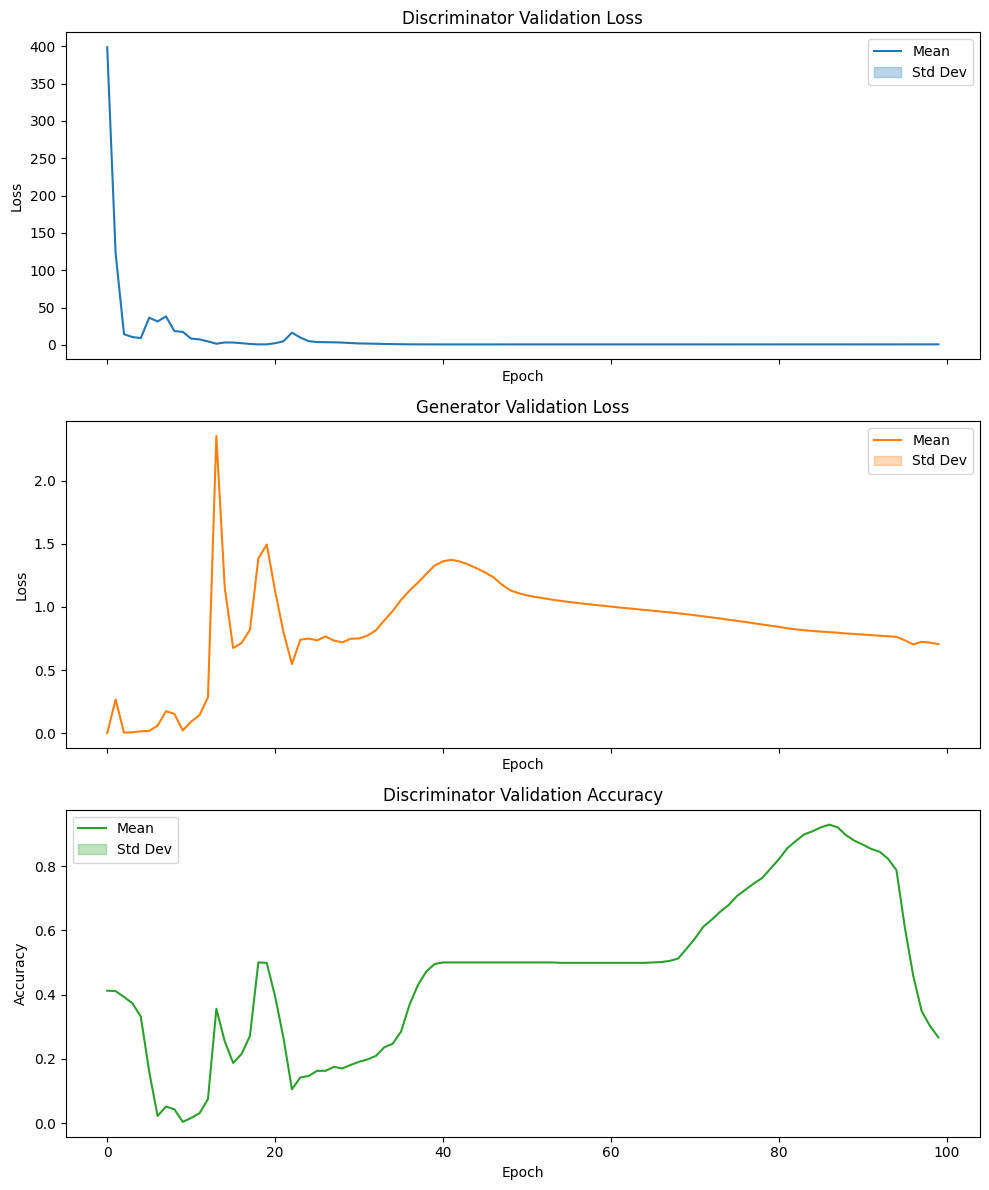

In [2]:
# Assuming the DataFrames are already filled and indexed by epoch:
# all_validation_d_losses, all_validation_d_accuracies, all_validation_g_losses

def plot_with_variance(ax, df, title, ylabel, color):
    mean_vals = df.mean(axis=1)
    std_vals = df.std(axis=1)
    epochs = df.index

    ax.plot(epochs, mean_vals, label='Mean', color=color)
    ax.fill_between(epochs, mean_vals - std_vals, mean_vals + std_vals,
                    alpha=0.3, color=color, label='Std Dev')
    ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(ylabel)
    ax.legend()

# Create the figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

plot_with_variance(axes[0], all_validation_d_losses,
                   "Discriminator Validation Loss", "Loss", color="tab:blue")

plot_with_variance(axes[1], all_validation_g_losses,
                   "Generator Validation Loss", "Loss", color="tab:orange")

plot_with_variance(axes[2], all_validation_d_accuracies,
                   "Discriminator Validation Accuracy", "Accuracy", color="tab:green")

plt.tight_layout()
plt.show()


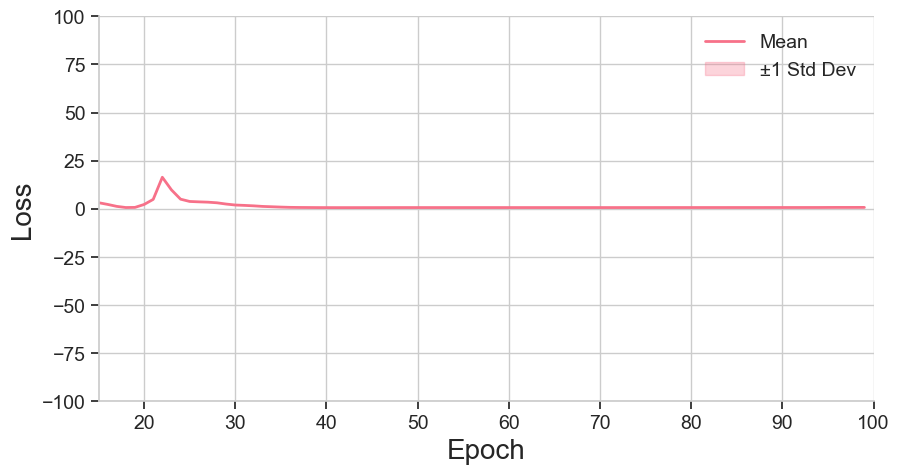

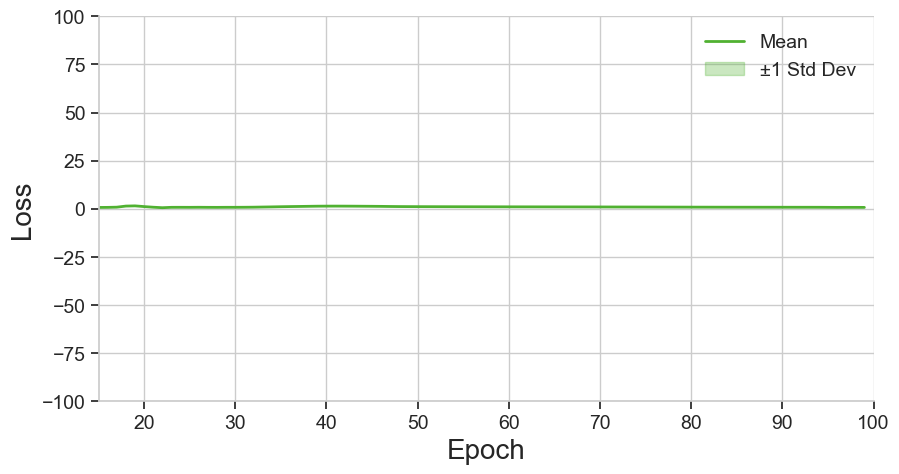

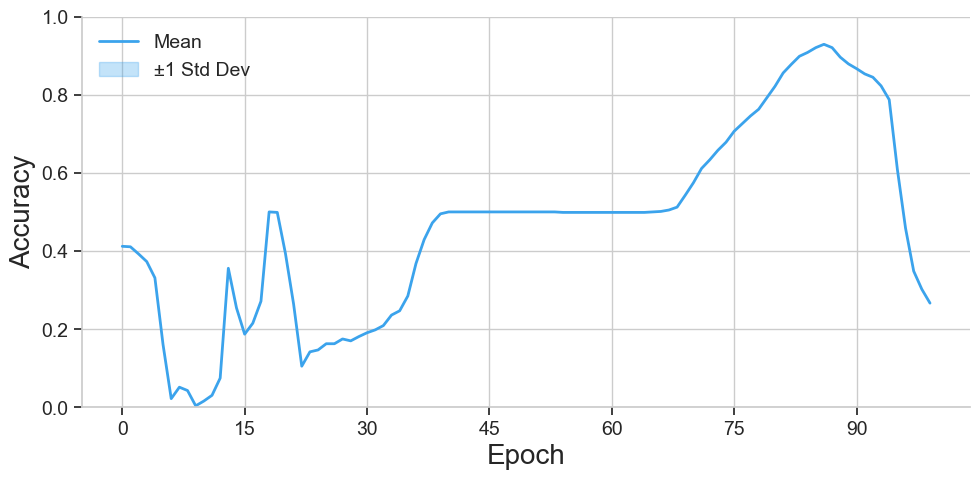

In [3]:
def plot_with_variance_sns(ax, df, title, ylabel, color, font_sizes=None):
    if font_sizes is None:
        font_sizes = {'title': 12, 'label': 10, 'tick': 9, 'legend': 9}
    
    mean_vals = df.mean(axis=1)
    std_vals = df.std(axis=1)
    epochs = df.index
    
    # Plot mean line
    ax.plot(epochs, mean_vals, label='Mean', color=color, linewidth=2)
    
    # Fill between for standard deviation
    ax.fill_between(epochs, np.maximum(mean_vals - std_vals, 0), mean_vals + std_vals,
                    alpha=0.3, color=color, label='±1 Std Dev')
    
    # Set labels and title with custom font sizes
    # ax.set_title(title, fontsize=font_sizes['title'], fontweight='bold')
    ax.set_xlabel("Epoch", fontsize=font_sizes['label'])
    ax.set_ylabel(ylabel, fontsize=font_sizes['label'])
    
    # Customize tick labels
    ax.tick_params(axis='both', which='major', labelsize=font_sizes['tick'])
    
    # Set x-tick labels to integers only
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Legend with custom font size
    ax.legend(fontsize=font_sizes['legend'])
    
    # Apply seaborn styling
    sns.despine(ax=ax)

# Set seaborn style
plt.style.use('seaborn-v0_8-whitegrid')  # Clean, professional look
sns.set_palette("husl")  # Better color palette for academic figures

# Define font sizes (easily tunable)
font_config = {
    # 'title': 14,  # Title font size
    'label': 20,   # Axis label font size
    'tick': 14,    # Tick label font size
    'legend': 14   # Legend font size
}

# Apply seaborn context for overall scaling
sns.set_context("notebook", font_scale=1.1)

# Create the figure and subplots
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

# Plot discriminator validation loss
# all_validation_d_losses_norm = all_validation_d_losses / all_validation_d_losses.max().max()
plot_with_variance_sns(axes, all_validation_d_losses,
                      "Discriminator Validation Loss", "Loss",
                      color=sns.color_palette("husl", 3)[0],
                      font_sizes=font_config)
axes.set_xlim([15,100]), axes.set_ylim([-100,100])

# Create the figure and subplots
fig2, axes2 = plt.subplots(1, 1, figsize=(10, 5))

# all_validation_g_losses_norm = all_validation_g_losses / all_validation_g_losses.max().max()
plot_with_variance_sns(axes2, all_validation_g_losses,
                      "Generator Validation Loss", "Loss",
                      color=sns.color_palette("husl", 3)[1],
                      font_sizes=font_config)
axes2.set_xlim([15,100]), axes2.set_ylim([-100,100])

# Create the figure and subplots
fig3, axes3 = plt.subplots(1, 1, figsize=(10, 5))

plot_with_variance_sns(axes3, all_validation_d_accuracies,
                      "Discriminator Validation Accuracy", "Accuracy",
                      color=sns.color_palette("husl", 3)[2],
                      font_sizes=font_config)
axes3.set_ylim([0,1])

# Adjust layout
plt.tight_layout()
plt.show()

In [4]:
joblib.dump(all_generated_p_values, parent_dir + '/notebooks/rq4_gan_results_seed/all_generated_p_values.pkl')

['/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN/notebooks/rq4_gan_results_seed/all_generated_p_values.pkl']

In [5]:
joblib.dump(all_real_pedge_values, parent_dir + '/notebooks/rq4_gan_results_seed/all_real_pedge_values.pkl')
joblib.dump(all_generated_v_values, parent_dir + '/notebooks/rq4_gan_results_seed/all_generated_v_values.pkl')
joblib.dump(all_generated_pedge_values, parent_dir + '/notebooks/rq4_gan_results_seed/all_generated_pedge_values.pkl')
joblib.dump(all_real_p_values, parent_dir + '/notebooks/rq4_gan_results_seed/all_real_p_values.pkl')
joblib.dump(all_real_v_values, parent_dir + '/notebooks/rq4_gan_results_seed/all_real_v_values.pkl')


joblib.dump(all_validation_d_losses, parent_dir + '/notebooks/rq4_gan_results_seed/all_validation_d_losses.pkl')
joblib.dump(all_validation_g_losses, parent_dir + '/notebooks/rq4_gan_results_seed/all_validation_g_losses.pkl')
joblib.dump(all_validation_d_accuracies, parent_dir + '/notebooks/rq4_gan_results_seed/all_validation_d_accuracies.pkl')

['/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN/notebooks/rq4_gan_results_seed/all_validation_d_accuracies.pkl']